In [1]:
import numpy as np
import pandas as pd

from etl import load_monsters, _mechanics, _stats, _flavor, _skills, get_monster_df

# Load data

In [2]:
monsters, ogl = load_monsters()
monster_df = get_monster_df(monsters)

In [3]:
from collections import namedtuple
from functools import partial

import re

get_dc = partial(re.findall,
                 re.compile(r'\bDC (\d+) (' \
                            + r'|'.join(stat.capitalize() for stat in _stats) \
                            + r')\b'))

get_dice = partial(re.findall, re.compile(r'\b(\d+)?d(\d+)\b'))

Summary = namedtuple('Summary', field_names='has_multiattack attack_bonus damage difficulty_class')

def summarize_actions(actions):
    has_multiattack = 1 if any('Multiattack' in action['name'] for action in actions) else 0
    action_summaries = [summarize(action) for action in actions]
    if action_summaries:
        max_attack_bonus = max(action['attack_bonus'] for action in action_summaries)
        max_damage = max(action['damage'] for action in action_summaries)
        max_difficulty_class = max(action['difficulty_class'] for action in action_summaries)
        summary = Summary(has_multiattack=has_multiattack, 
                          attack_bonus=max_attack_bonus, 
                          damage=max_damage, 
                          difficulty_class=max_difficulty_class)
    else:
        summary = Summary(has_multiattack=0,
                          attack_bonus=2,
                          damage=1,
                          difficulty_class=10)
    return summary


def summarize(action):
    difficulty_class = get_dc(action['desc'])
    attack_bonus = int(action.get('attack_bonus', '0'))
    damage_dice = action.get('damage_dice', '0d0')
    damage_bonus = int(action.get('damage_bonus', '0'))
    return {'attack_bonus': attack_bonus,
            'damage': get_damage_potential(damage_dice, damage_bonus),
            'difficulty_class': get_max_dc(difficulty_class)}

def get_damage_potential(damage_dice, damage_bonus):
    damage = damage_bonus
    for roll in damage_dice.split(' + '):
        n, size = get_dice(roll)[0]
        damage += int(n) * int(size)
    return damage

def get_max_dc(difficulty_class):
    if difficulty_class:
        return max([int(x[0]) for x in difficulty_class if x])
    else:
        return 10

In [4]:
attacks = monster_df.actions.apply(summarize_actions)

In [5]:
attacks_df = pd.concat([attacks.map(lambda x: x[i]) for i in range(4)], axis=1)
attacks_df.columns = 'has_multiattack attack_bonus damage difficulty_class'.split(' ')

## Load training data

In [6]:
def load_Xy():
    return (pd.concat([monster_df[['armor_class', 'hit_points']], attacks_df], axis=1),
            monster_df[['challenge_rating']])

X, y = load_Xy()

# quick linear model

In [7]:
from sklearn.linear_model import LinearRegression
from plotnine import (aes, geom_abline, geom_point, ggplot)


/Users/jason/Code/cr/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [8]:
lr = LinearRegression()
lr.fit(X, y)

pred = y.copy()
pred['cr_hat'] = lr.predict(X)

/Users/jason/Code/cr/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


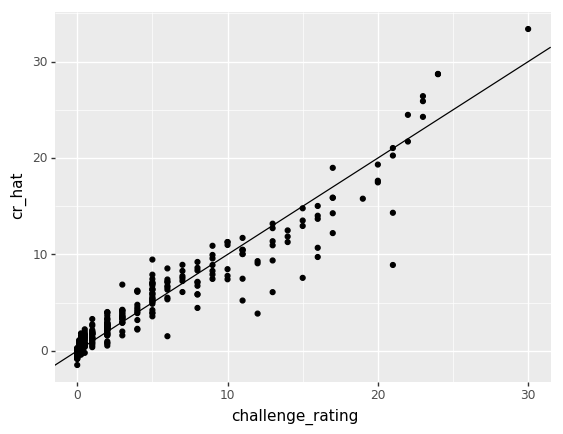

<ggplot: (289648746)>

In [9]:
ggplot(pred, aes(x='challenge_rating', y='cr_hat')) + geom_point() + geom_abline(intercept = 0, slope = 1)

### [todo] What is `lr.score` reporting?

In [10]:
lr.score(X, y)

0.91243233372362997

In [11]:
X.shape

(325, 6)

# Simple neural network

To build our model, we'll use Keras.

In [12]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD

from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


Our model will consist of a single perceptron with a linear activation.

In [13]:
# A simple example of linear regression.

shape = X.shape[1]

model = Sequential()
model.add(Dense(1, input_shape=(shape,), activation='linear'))

model.compile(loss='mean_squared_error', optimizer=SGD())

For a linear perceptron, the training speed is highly sensitive to differences in scale. Thus, we pre-process the data with the `StandardScaler`.

In [14]:
# Pre-processing
scale_x, scale_y = StandardScaler(),  StandardScaler()
sX = scale_x.fit_transform(X)
sy = scale_y.fit_transform(y)

As we're not interested in using this model for prediction, we'll simply train over the entire dataset.

In [15]:
# training
network_history = model.fit(sX, sy, epochs=20, verbose=0)

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 7         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


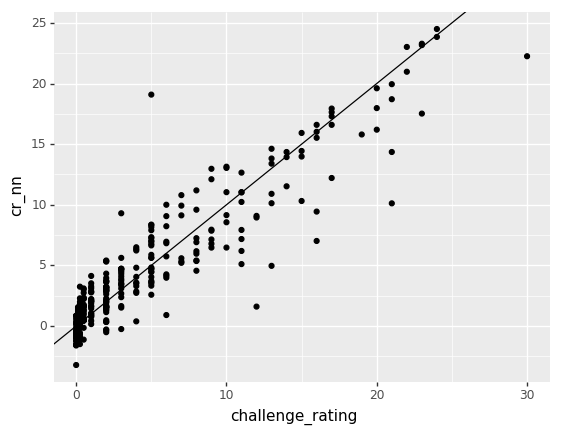

<ggplot: (300745171)>

In [17]:
y_hat = scale_y.inverse_transform(model.predict(sX))
pred['cr_nn'] = y_hat

ggplot(pred, aes(x='challenge_rating', y='cr_nn')) + geom_point() + geom_abline(intercept = 0, slope = 1)

The difference in results between linear regression and the neural network are due entirely to the optimization strategies. In the case of sci-kit learn, regression is simply a matter of linear algebra, whereas our model makes use of stocastic gradient descent.

In this particular example, the loss function is convex, and so in the limit (as `epoch` $\to \infty$) the weights converge to the weights of the linear regression.

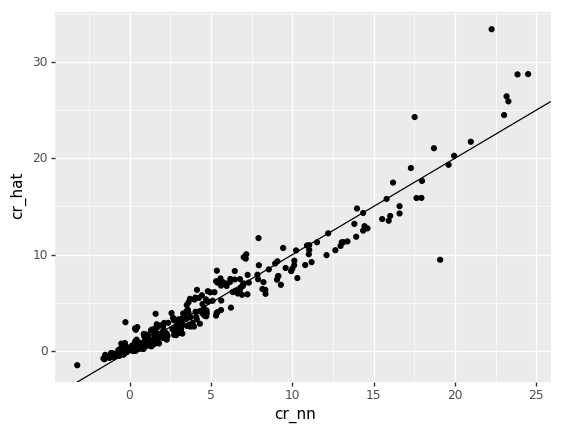

<ggplot: (300780513)>

In [18]:
ggplot(pred, aes(x='cr_nn', y='cr_hat')) + geom_point() + geom_abline(intercept = 0, slope = 1)

### [TODO] Add interactive visualization of the above data

# DeepDreaming - or perturbing inputs for fun and profit??
DeepDreaming is a surprisingly simple technique, which was first applied to visualizing hidden layer activations of deep neural nets trained on image data. This application was first described in this Google research blog [post](https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html) ([source](https://github.com/google/deepdream/blob/master/dream.ipynb)). The example source (originally built using Caffe) was later [ported](https://github.com/fchollet/keras/blob/master/examples/deep_dream.py) to Keras.

In the following, we'll adapt this basic idea to our very simple model. We'll then generalize to more complicated models.

In [19]:
from keras import backend as K

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 7         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


In [21]:
X.head()

,armor_class,hit_points,has_multiattack,attack_bonus,damage,difficulty_class
name,,,,,,
Aboleth,17,135,1,9,23,14
Acolyte,10,9,0,2,4,10
Adult Black Dragon,19,195,1,11,96,18
Adult Blue Dracolich,19,225,1,12,120,20
Adult Blue Dragon,19,225,1,12,120,19


In [22]:
K.set_learning_phase(0) # 0 = test, 1 = train
layer_dict = {layer.name: layer for layer in model.layers}

dream = model.input

In [23]:
dream

<tf.Tensor 'dense_1_input:0' shape=(?, 6) dtype=float32>

In [24]:
X.columns

Index(['armor_class', 'hit_points', 'has_multiattack', 'attack_bonus',
       'damage', 'difficulty_class'],
      dtype='object')

In [25]:
# use a mask
mask = np.array([True, False, True, False, False, True])
T = np.eye(6)[mask]
K.dot(dream, K.constant(T.transpose()))

<tf.Tensor 'MatMul:0' shape=(?, 3) dtype=float32>

In [26]:
# we can build an injective map by using `K.dot` and pointwise addition

a = K.constant([[1, 0], [0, 1]], dtype='float32')
b = K.constant([[5, 6], [7, 8]], dtype='float32')

t = a * b # pointwise product
t = a + b # pointwise addition
t = K.dot(a, b) # matrix product
K.eval(t)

array([[ 5.,  6.],
       [ 7.,  8.]], dtype=float32)

In [27]:
TARGET = scale_y.transform(5)

# build new loss function
target = K.constant(TARGET, dtype='float32')
loss = K.variable(0, dtype='float32')
coeff = 1.
x = layer_dict['dense_1'].output - target
scaling = K.prod(K.cast(K.shape(x), 'float32')) # number of entries in x
loss = coeff * K.sum(K.square(x)) / scaling

# Compute the gradients of loss wrt the dream, and normalize.
grads = K.gradients(loss, dream)[0]
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

# Set up function to retrieve the value of the loss and gradients given an input.
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs) # why [dream]? inputs to a TensorFlow backend
                                                    # function should be a list or tuple

def eval_loss_and_grads(x):
    return fetch_loss_and_grads([x])

def gradient_descent(x, iterations, step, max_loss=None):
    # can we use the build in gradient models as well?
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            raise Exception('Loss value {} is larger then the max_loss'.format(loss_value))
        x -= step * grad_values
        yield x, loss_value
    return

# build a couple of different ways to access this tool

In [28]:
X.head()

,armor_class,hit_points,has_multiattack,attack_bonus,damage,difficulty_class
name,,,,,,
Aboleth,17,135,1,9,23,14
Acolyte,10,9,0,2,4,10
Adult Black Dragon,19,195,1,11,96,18
Adult Blue Dracolich,19,225,1,12,120,20
Adult Blue Dragon,19,225,1,12,120,19


In [29]:
x = X.loc['Aboleth'].reshape(1, -1)
sx = scale_x.transform(x)

# hyperparameters

step = 0.01  # Gradient ascent step size
iterations = 200  # Number of ascent steps per scale
max_loss = 10. # worth thinking about

# how should I fix parameters? I want to factor through an injective map
# ANSWER: use a matrix multiplication.

# gotta try this!
history = gradient_descent(sx, iterations, step, max_loss)

/Users/jason/Code/cr/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.
/Users/jason/Code/cr/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


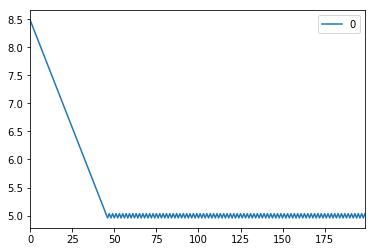

In [30]:
x_vals = list()
y_vals = list()

for x, loss in history:
    x_vals.append(scale_x.inverse_transform(x)[0])
    y = scale_y.inverse_transform(model.predict(x))[0][0]
    y_vals.append(y)
    
% matplotlib inline
pd.DataFrame(y_vals).plot()

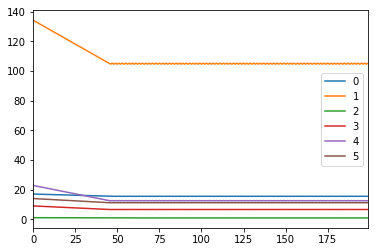

In [31]:
pd.DataFrame(x_vals).plot()

use `floor` and `ceil` from `math`, as well as `itertools.product` to construct samples

# Generalizing to neural networks with hidden layers

The generalization is quite easy! We'll first begin by building a more complicated model.